# User Behaviour Analysis Based on Borrowing Dates

The aim of the notebook is to analyze user behavior based on the date of borrowing in order to create a kind of user profile. The following questions should be answered:
1. Do users have a routine when visiting the library? This initially refers to the day of the week on which users borrow items. Can consistency be identified on a particular day?
2. Can a more detailed user type be identified by including the time of day?

In [1]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [2]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [3]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"
USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"
LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")
borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



### Prepare dataframe for analysis

In [4]:
df_time = borrowings.copy()
df_time = df_time.sort_values(by=[USER_ID_COL, ISSUE_COL])

MAX_GAP = pd.Timedelta(minutes=30)

df_time['time_diff'] = df_time.groupby(USER_ID_COL)[ISSUE_COL].diff()
df_time['is_new_session'] = (df_time['time_diff'] > MAX_GAP) | (df_time['time_diff'].isna())
df_time['session_id'] = df_time.groupby(USER_ID_COL)['is_new_session'].cumsum()

user_sessions = df_time.groupby([USER_ID_COL, 'session_id']).agg({
    ISSUE_COL: 'first',
    USER_CATEGORY_COL: 'first',
    'late_bool': 'max',
    'is_new_session': 'size'
}).reset_index()

user_sessions = user_sessions.rename(columns={'is_new_session': 'items_count'})
user_sessions["weekday"] = user_sessions[ISSUE_COL].dt.day_name()
user_sessions["hour"] = user_sessions[ISSUE_COL].dt.hour
user_sessions["seconds_since_midnight"] = (
    user_sessions[ISSUE_COL].dt.hour * 3600 +
    user_sessions[ISSUE_COL].dt.minute * 60 +
    user_sessions[ISSUE_COL].dt.second
)
user_sessions["precise_hour"] = user_sessions["seconds_since_midnight"] / 3600
user_sessions["date"] = user_sessions[ISSUE_COL].dt.date



Clean up data set for analysis:
1. Remove outliers (time = midnight)
2. Remove loans that take place on the main closing days (Monday and Sunday)
3. Filter by users who have made at least MIN_SESSIONS loans

In [5]:
MIN_SESSIONS = 10

# --- Remove midnight outliers ---
midnight_sessions = user_sessions[
    (user_sessions[ISSUE_COL].dt.hour == 0) &
    (user_sessions[ISSUE_COL].dt.minute == 0) &
    (user_sessions[ISSUE_COL].dt.second == 0)
]
user_sessions_clean = user_sessions[~(
    (user_sessions[ISSUE_COL].dt.hour == 0) &
    (user_sessions[ISSUE_COL].dt.minute == 0)
)].copy()

print(f"Sessions at exactly midnight (removed): {len(midnight_sessions)}")


# --- Remove loans on main closing days (Monday and Sunday) ---
closing_day_mask = user_sessions_clean[ISSUE_COL].dt.weekday.isin([0, 6])
closing_day_sessions = user_sessions_clean[closing_day_mask]
user_sessions_clean = user_sessions_clean[~closing_day_mask].copy()

print(f"Sessions on closing days (Monday and Sunday) removed: {len(closing_day_sessions)}")


# --- Filter users with at least MIN_SESSIONS ---
user_counts = user_sessions_clean.groupby(USER_ID_COL).size()
frequent_user = user_counts[user_counts >= MIN_SESSIONS].index
user_sessions_clean = user_sessions_clean[user_sessions_clean[USER_ID_COL].isin(frequent_user)].copy()



user_sessions_clean = user_sessions_clean[user_sessions_clean[USER_ID_COL].isin(frequent_user)].copy()
print(f"Analyzing {len(frequent_user)} users with at least {MIN_SESSIONS} visits and in total {len(user_sessions_clean)} sessions.")


Sessions at exactly midnight (removed): 7
Sessions on closing days (Monday and Sunday) removed: 15203
Analyzing 9417 users with at least 10 visits and in total 395602 sessions.


In [6]:
user_sessions_clean.head()

,Benutzer-Systemnummer,session_id,Ausleihdatum/Uhrzeit,Benutzerkategorie,late_bool,items_count,weekday,hour,seconds_since_midnight,precise_hour,date
6,50,4.0000,2019-01-22 08:27:39,MPA,False,4,Tuesday,8,30459,8.4608,2019-01-22
7,50,5.0000,2019-01-22 12:09:46,MPA,False,2,Tuesday,12,43786,12.1628,2019-01-22
8,50,6.0000,2019-01-24 09:20:58,MPA,False,1,Thursday,9,33658,9.3494,2019-01-24
9,50,7.0000,2019-01-24 10:59:35,MPA,False,2,Thursday,10,39575,10.9931,2019-01-24
10,50,8.0000,2019-01-24 15:07:45,MPA,False,1,Thursday,15,54465,15.1292,2019-01-24


## Analysis of user routine and weekday consistency

Quantify user routine by calculating the distribution of visits across weekdays and identifying the share of visits occurring on the most frequent day (Favorite Day Consistency)


In [7]:
session_day_counts = user_sessions_clean.groupby([USER_ID_COL, 'weekday']).size().unstack(fill_value=0)

day_consistency = (session_day_counts.max(axis=1) / session_day_counts.sum(axis=1)) * 100

print(f"Based on {len(day_consistency)} users with >= {MIN_SESSIONS} visits.")
print(day_consistency.describe())

Based on 9417 users with >= 10 visits.
count   9,417.0000
mean       38.8038
std        11.9053
min        20.5882
25%        30.4348
50%        36.1111
75%        43.7500
max       100.0000
dtype: float64


In [8]:
session_day_counts.head()

weekday,Friday,Saturday,Thursday,Tuesday,Wednesday
Benutzer-Systemnummer,,,,,
50,131,58,158,263,202
51,2,1,6,6,1
54,51,43,40,48,48
55,39,0,34,48,18
57,35,4,52,67,50



The mean consistency of 38.8% indicates that, on average users perform nearly 40% of their borrowing sessions on their most preferred weekday. Compared to a theoretical random distribution of 20% (assuming 5 opening days), this could suggest a behavioral routine among frequent users

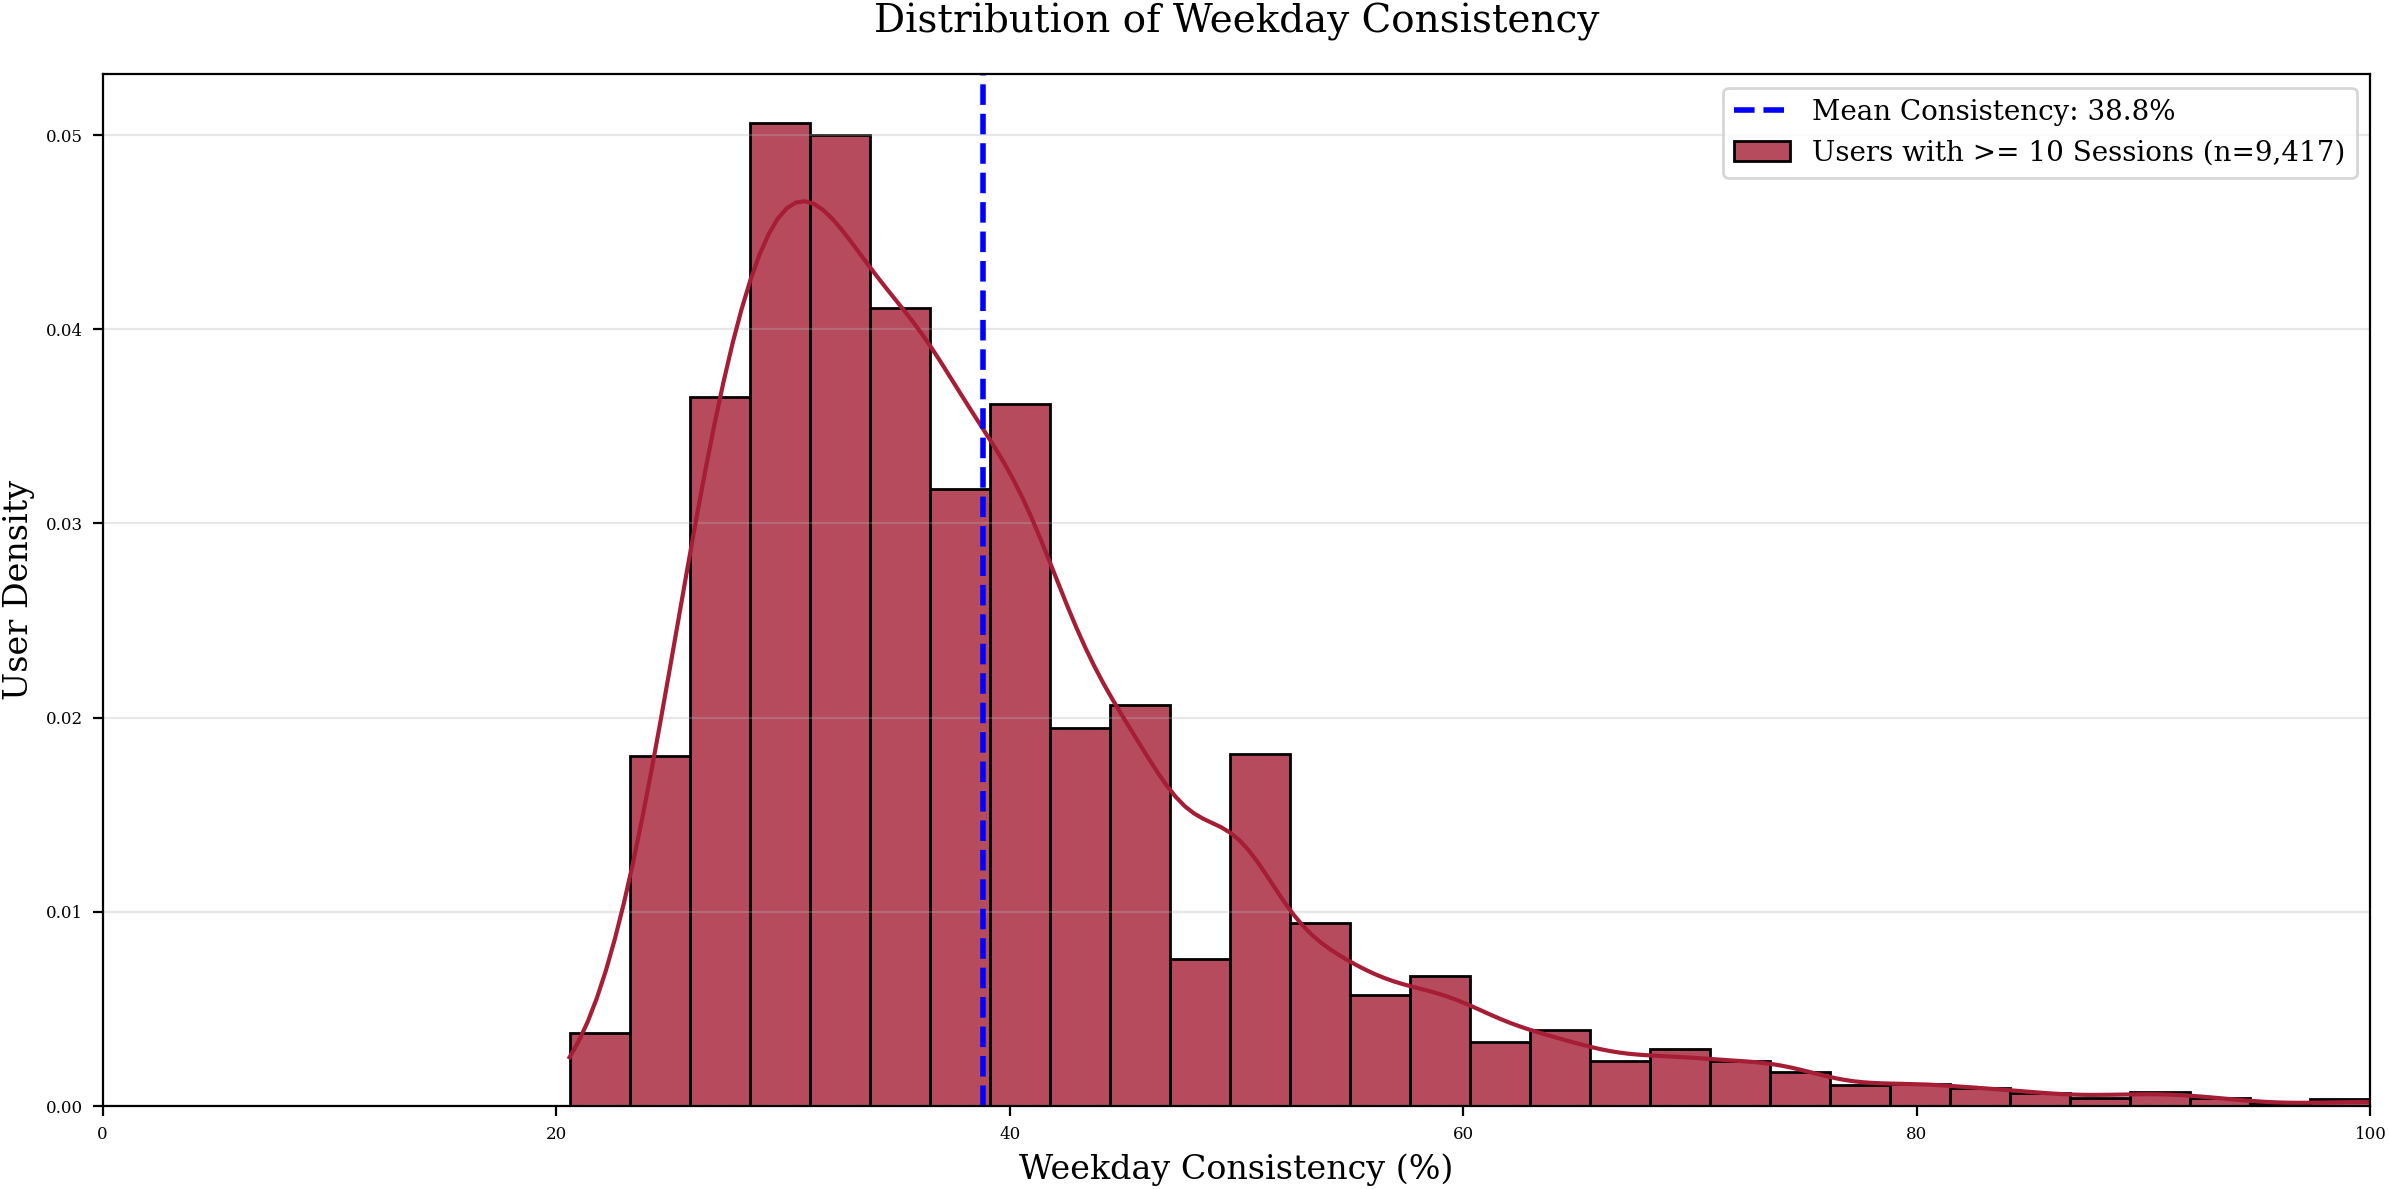

In [9]:

mean_val = day_consistency.mean()

plt.figure(figsize=(12, 6))
sns.histplot(
    day_consistency,
    bins=30,
    kde=True,
    alpha=0.8,
    label=f'Users with >= {MIN_SESSIONS} Sessions (n={len(day_consistency):,})',
    stat="density",
    common_norm=False
)

plt.axvline(
    mean_val,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Mean Consistency: {mean_val:.1f}%'
)

plt.title('Distribution of Weekday Consistency', fontsize=14, pad=15)
plt.xlabel('Weekday Consistency (%)', fontsize=12)
plt.ylabel('User Density', fontsize=12)
plt.xlim(0, 100)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

## Analysis of borrowing time

### Library usage on a specific day

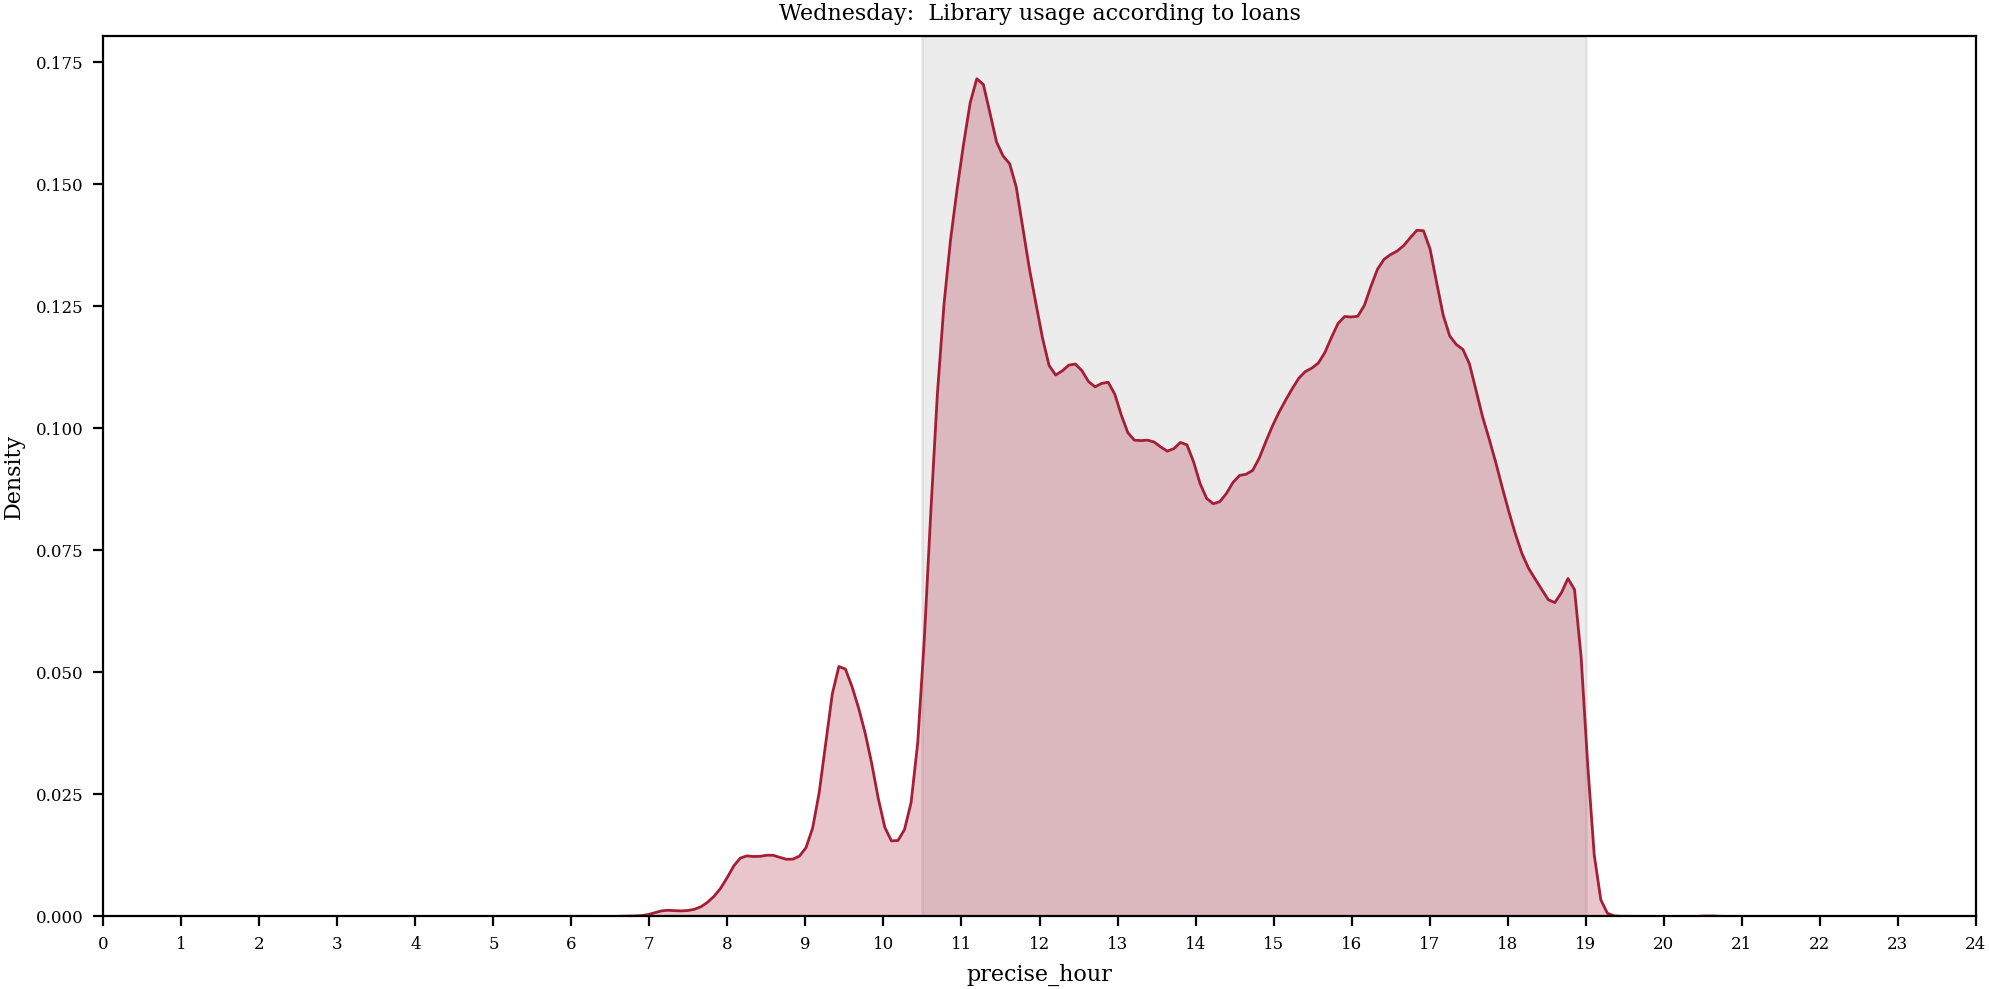

In [10]:
DAY = "Wednesday"
day_data = user_sessions_clean[user_sessions_clean["weekday"] == DAY]

plt.figure(figsize=(10, 5))
plt.axvspan(10.5, 19.0, color='gray', alpha=0.15, label='Official Opening Hours')

sns.kdeplot(
    data=day_data,
    x="precise_hour",
    fill=True,
    bw_adjust=0.4,
)

plt.xlim(0, 24)
plt.xticks(range(0, 25))
plt.title(f"{DAY}:  Library usage according to loans")
plt.show()

### Analysis of average loan time per user

In [11]:
user_time_behavior = user_sessions_clean.groupby(USER_ID_COL).agg({
    'precise_hour': ['mean', 'std', 'count'],
    'weekday': lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
})
user_time_behavior.columns = ['avg_hour', 'hour_spread', 'visit_count', 'fav_day']
user_time_behavior['day_consistency'] = day_consistency
mean_hour_spread = user_time_behavior['hour_spread'].mean()


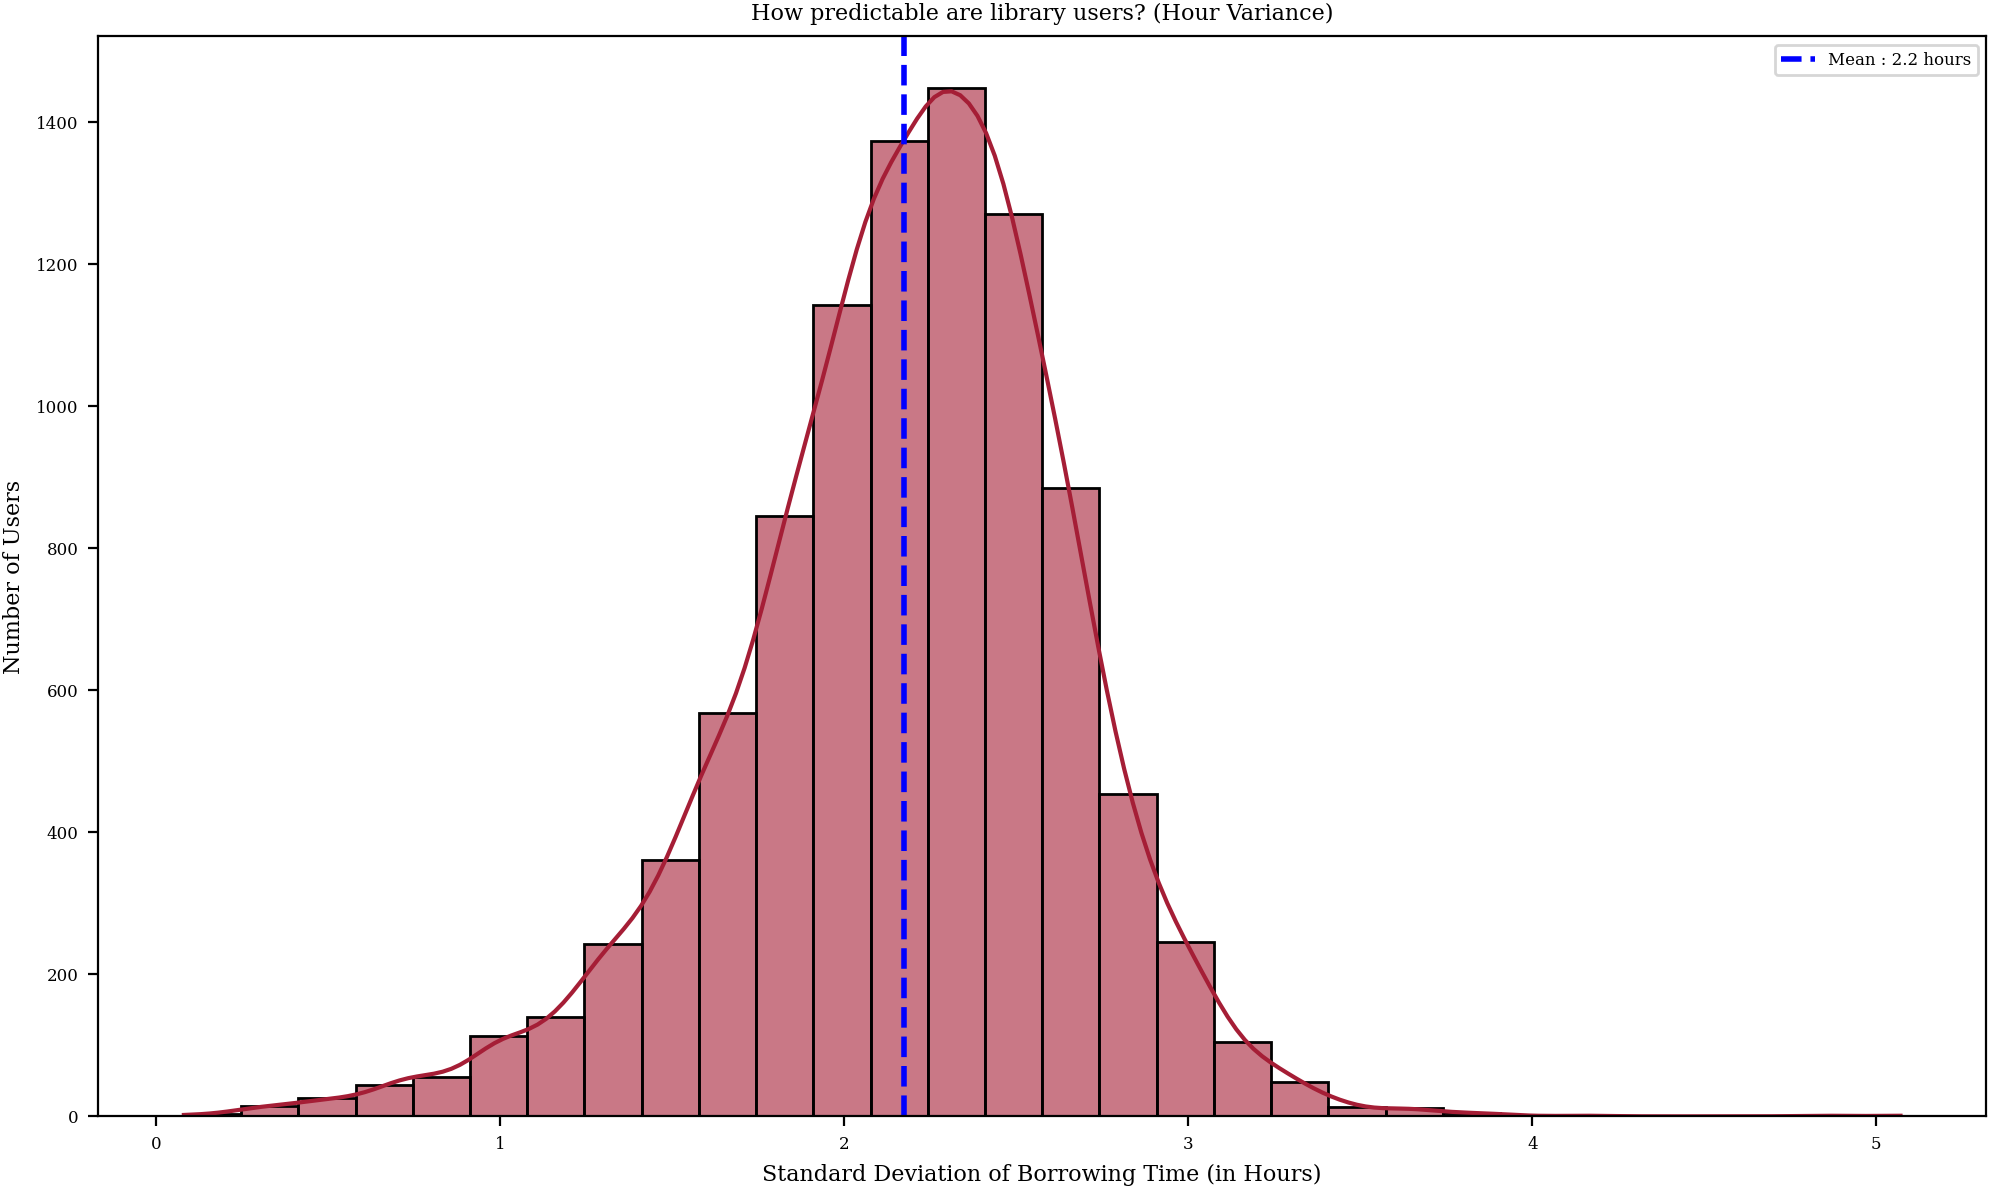

2.1% of users show high routine (±1 hour).
3.0% of users arrive at completely different times (>3h spread).


In [23]:
plt.figure(figsize=(10, 6))

sns.histplot(user_time_behavior['hour_spread'], bins=30, kde=True, alpha=0.6)
plt.axvline(
    mean_hour_spread,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Mean : {mean_hour_spread:.1f} hours'
)
plt.title("How predictable are library users? (Hour Variance)")
plt.xlabel("Standard Deviation of Borrowing Time (in Hours)")
plt.ylabel("Number of Users")
plt.legend()
plt.show()


low_var = (user_time_behavior['hour_spread'] <= 1.0).sum() / len(user_time_behavior['hour_spread']) * 100
high_var = (user_time_behavior['hour_spread'] > 3.0).sum() / len(user_time_behavior['hour_spread']) * 100

print(f"{low_var:.1f}% of users show high routine (±1 hour).")
print(f"{high_var:.1f}% of users arrive at completely different times (>3h spread).")

### How does the standard deviation behave over the day?

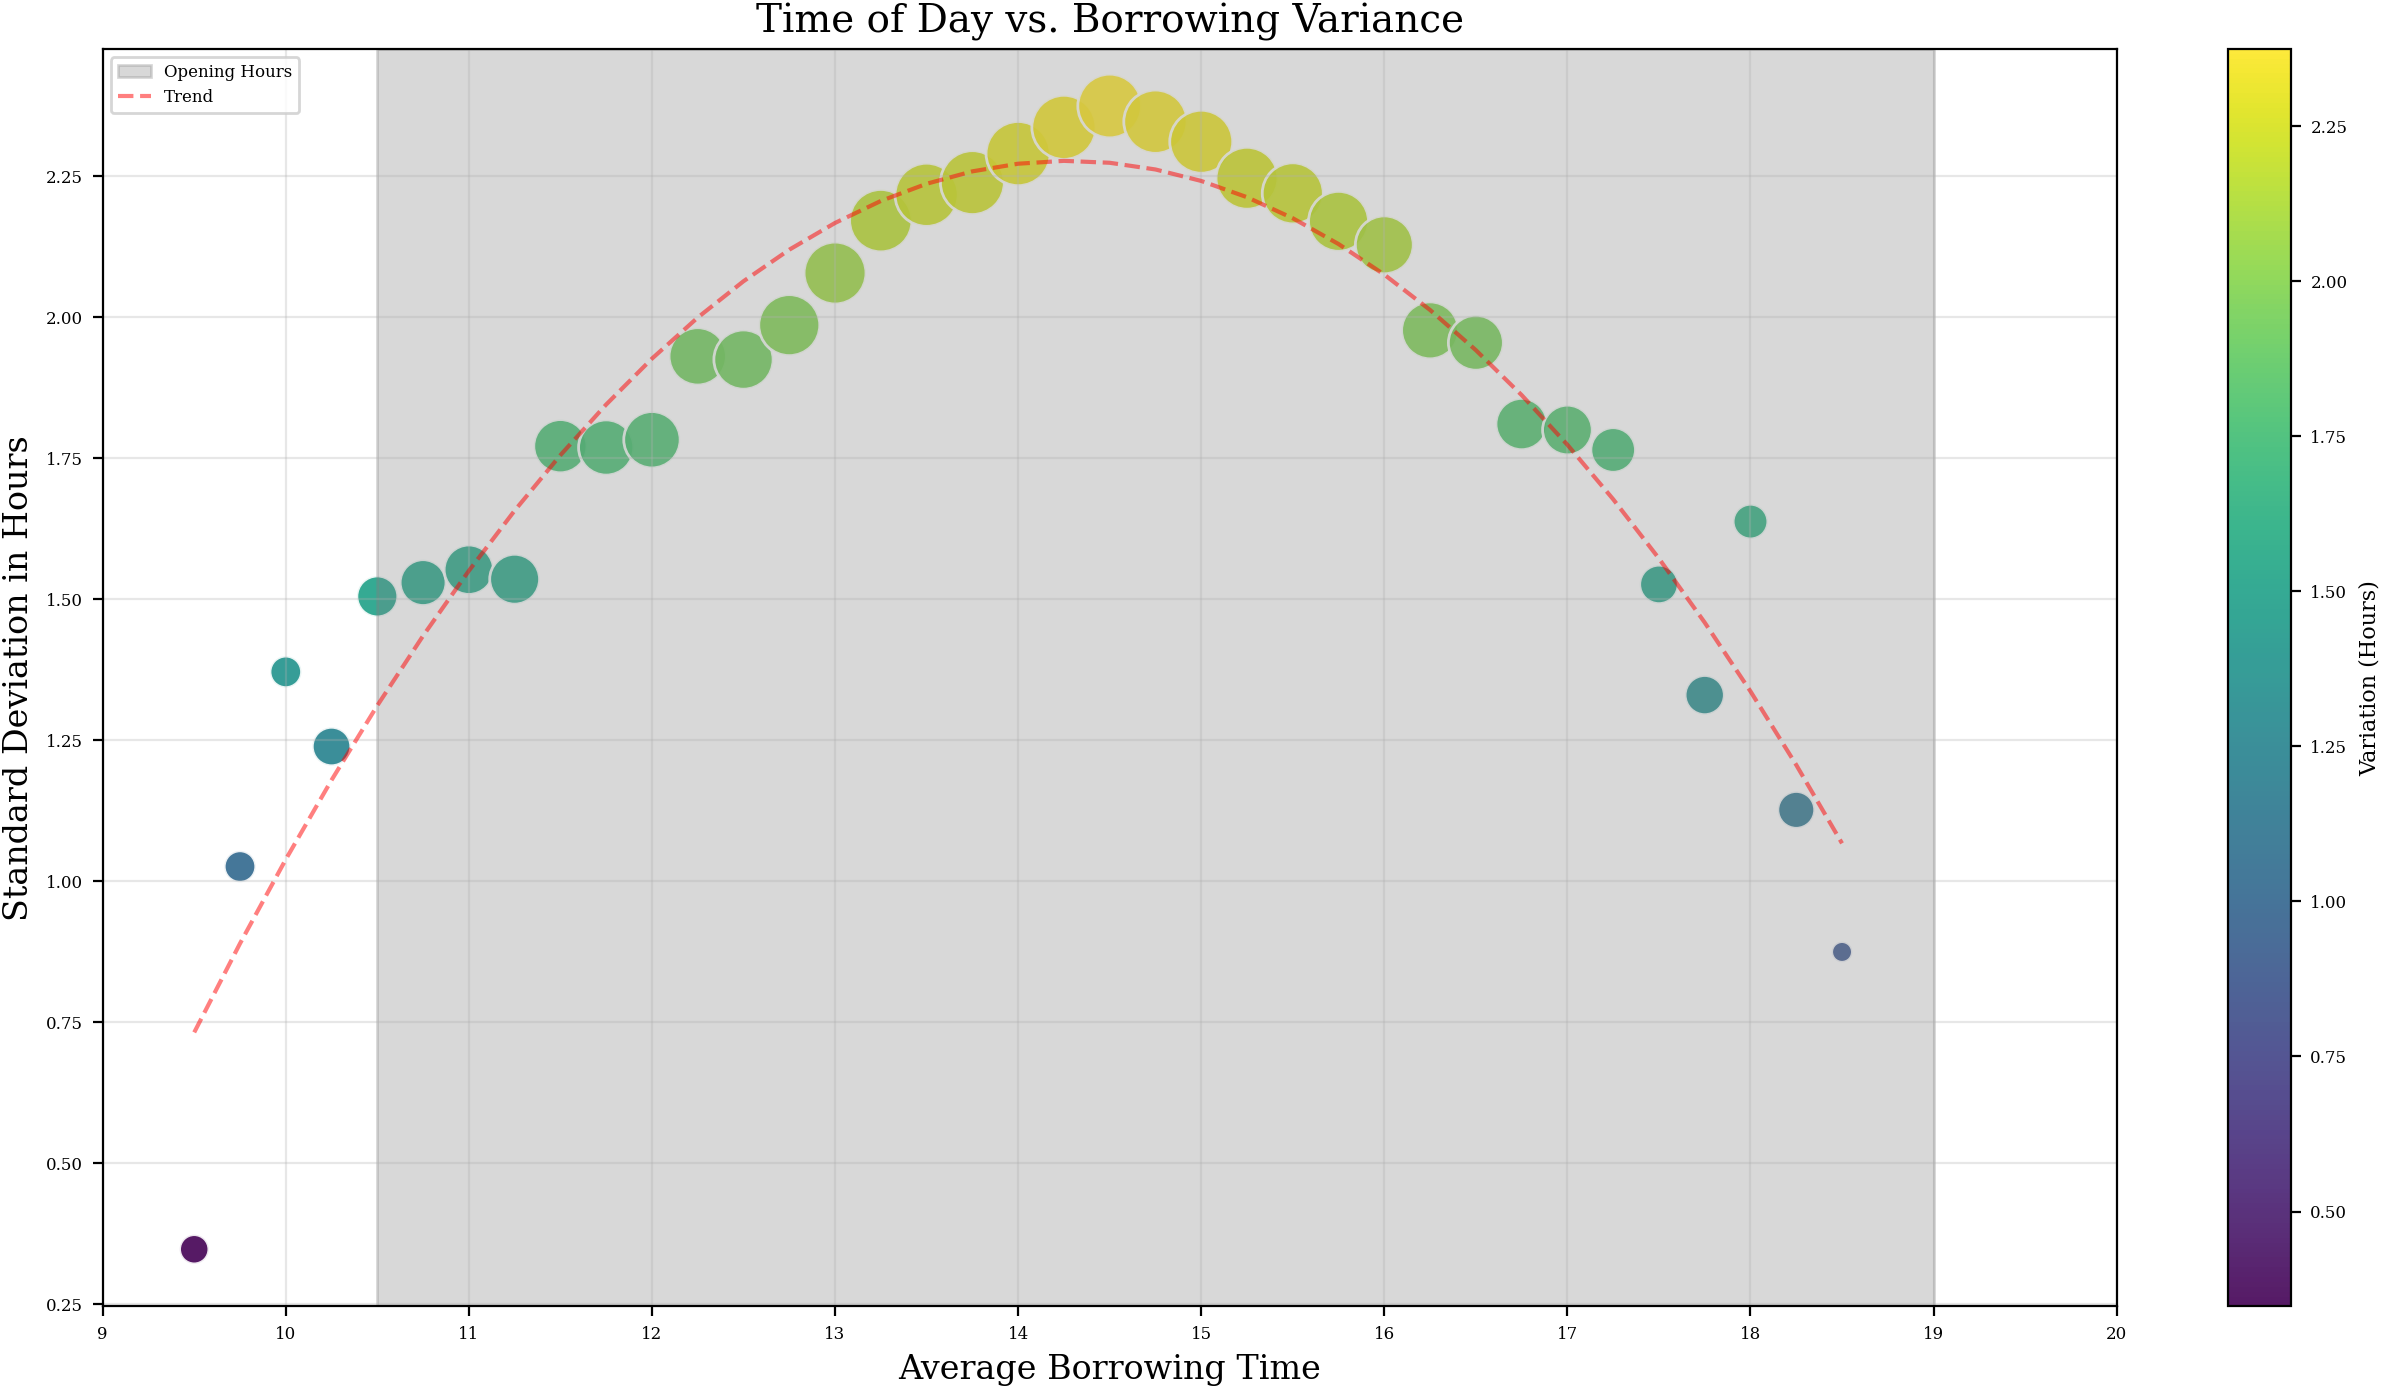

In [13]:
user_time_behavior['hour_bin'] = (user_time_behavior['avg_hour'] * 4).round() / 4

stability_map = user_time_behavior.groupby('hour_bin').agg({
    'hour_spread': 'mean',
    'visit_count': 'count'
}).reset_index()

stability_map = stability_map[(stability_map['hour_bin'] >= 6) & (stability_map['hour_bin'] <= 22)]

plt.figure(figsize=(12, 7))

scatter = plt.scatter(
    x=stability_map['hour_bin'],
    y=stability_map['hour_spread'],
    s = np.log1p(stability_map['visit_count']) * 80,
    c=stability_map['hour_spread'],
    cmap='viridis',
    alpha=0.9,
    edgecolors='w'
)

plt.axvspan(10.5, 19.0, color='gray', alpha=0.3, label='Opening Hours')

z = np.polyfit(stability_map['hour_bin'], stability_map['hour_spread'], 2)
p = np.poly1d(z)
plt.plot(stability_map['hour_bin'], p(stability_map['hour_bin']), "r--", alpha=0.5, label='Trend')

plt.title("Time of Day vs. Borrowing Variance", fontsize=14)
plt.xlabel("Average Borrowing Time", fontsize=12)
plt.ylabel("Standard Deviation in Hours", fontsize=12)
plt.xticks(range(9, 21))
plt.grid(axis='both', alpha=0.3)
plt.colorbar(scatter, label='Variation (Hours)')
plt.legend()

plt.show()

## User segmentation: Combining the two findings: consistency in the day (how confidently does a user visit on the same day) and how high is the Standard Deviation of borrowing time

9417


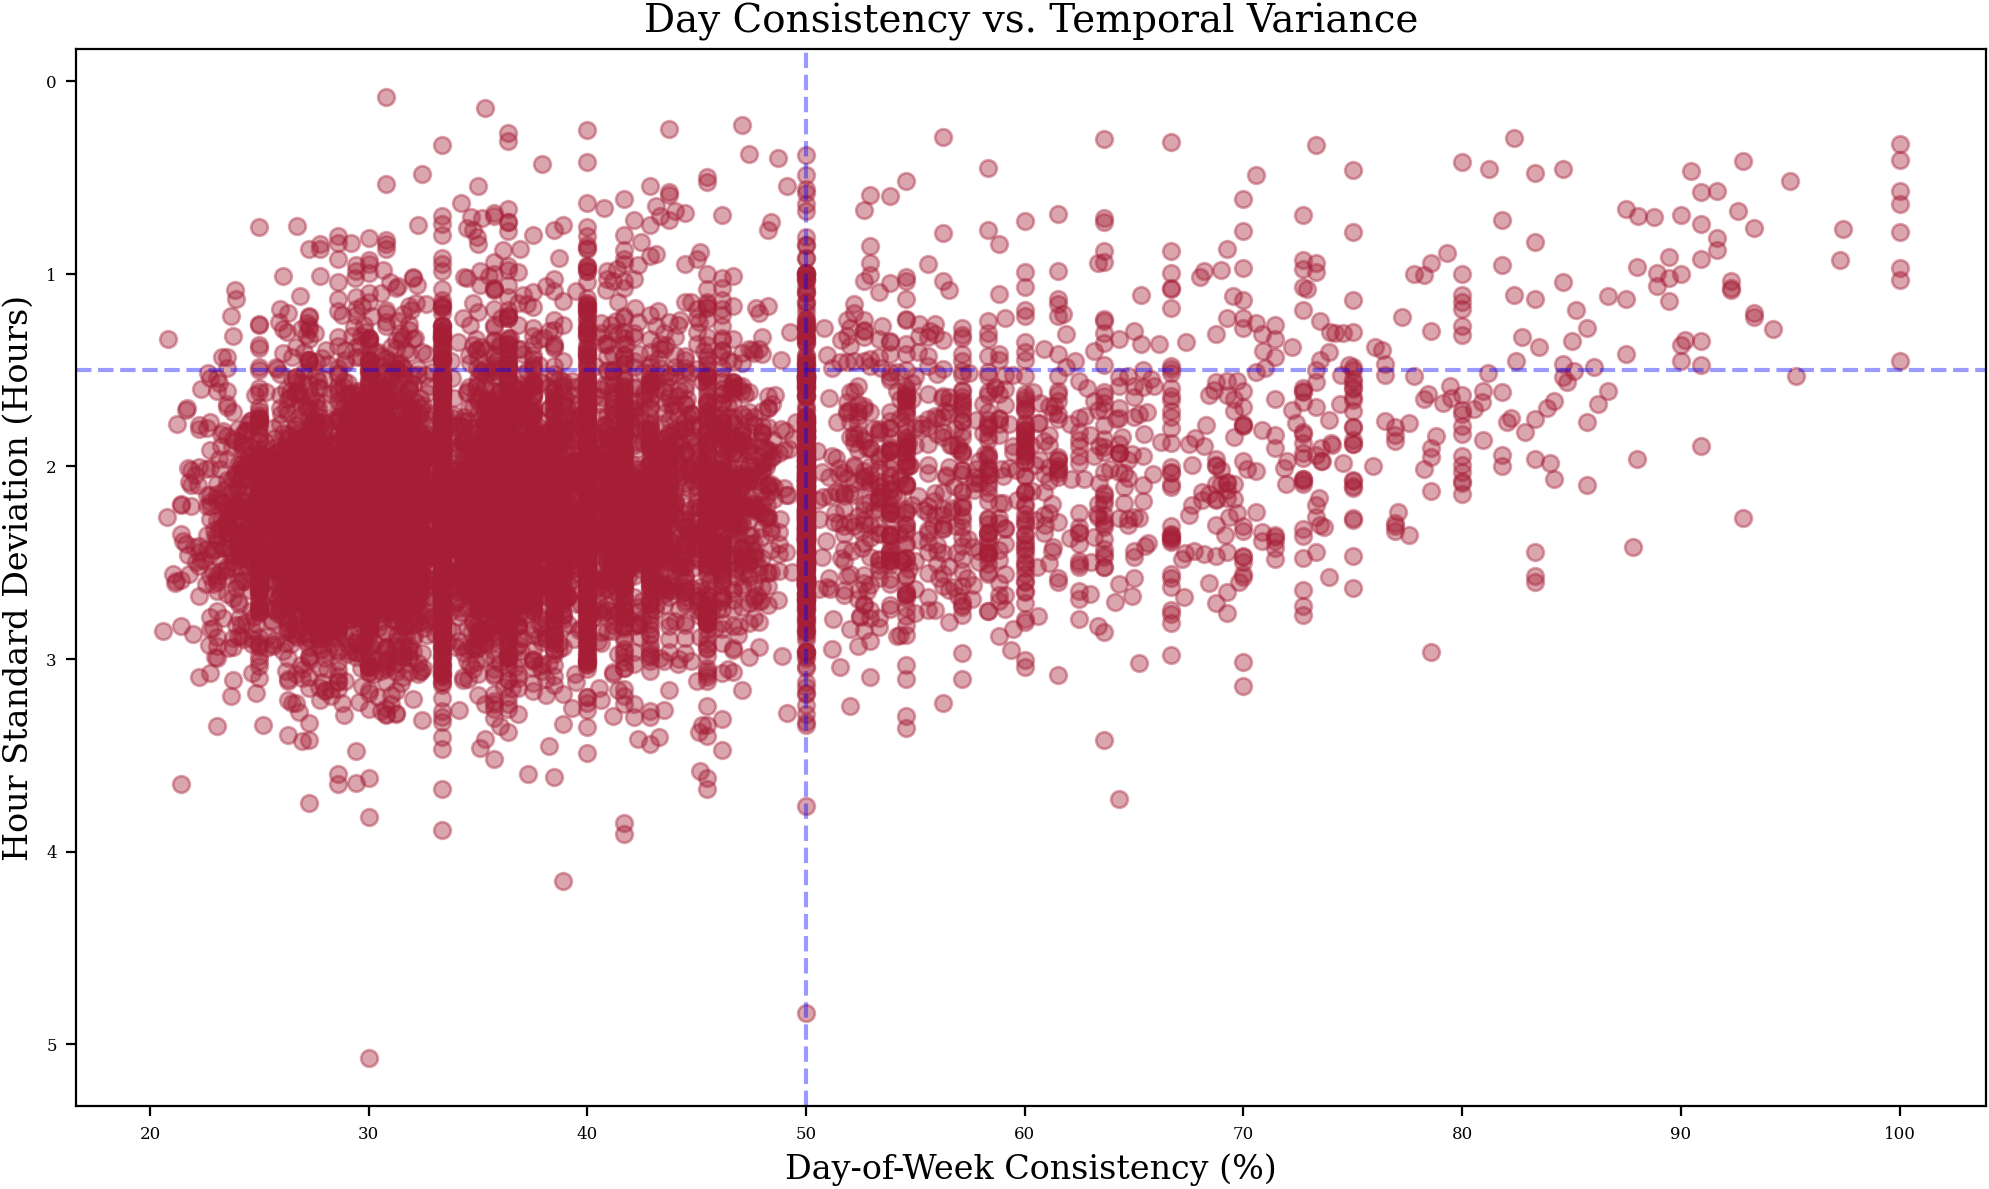

In [14]:

cluster_df = user_time_behavior[['avg_hour', 'hour_spread', 'visit_count']].copy()
cluster_df = user_time_behavior[user_time_behavior['visit_count'] >= MIN_SESSIONS].copy()
cluster_df['day_consistency'] = day_consistency

print(len(cluster_df))

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    x=cluster_df['day_consistency'],
    y=cluster_df['hour_spread'],
    alpha=0.4
)

plt.axvline(x=50, color='blue', linestyle='--', alpha=0.4)
plt.axhline(y=1.5, color='blue', linestyle='--', alpha=0.4)

plt.title("Day Consistency vs. Temporal Variance", fontsize=14)
plt.xlabel("Day-of-Week Consistency (%)", fontsize=12)
plt.ylabel("Hour Standard Deviation (Hours)", fontsize=12)
plt.gca().invert_yaxis()

plt.show()

Calculating 50 permutations...

--- Quantification of Results ---
Mean Entropy (Observed):   2.535
Mean Entropy (Randomized): 2.841
P-Value:                   0.0000
---------------------------------


/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_2113/3217314760.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


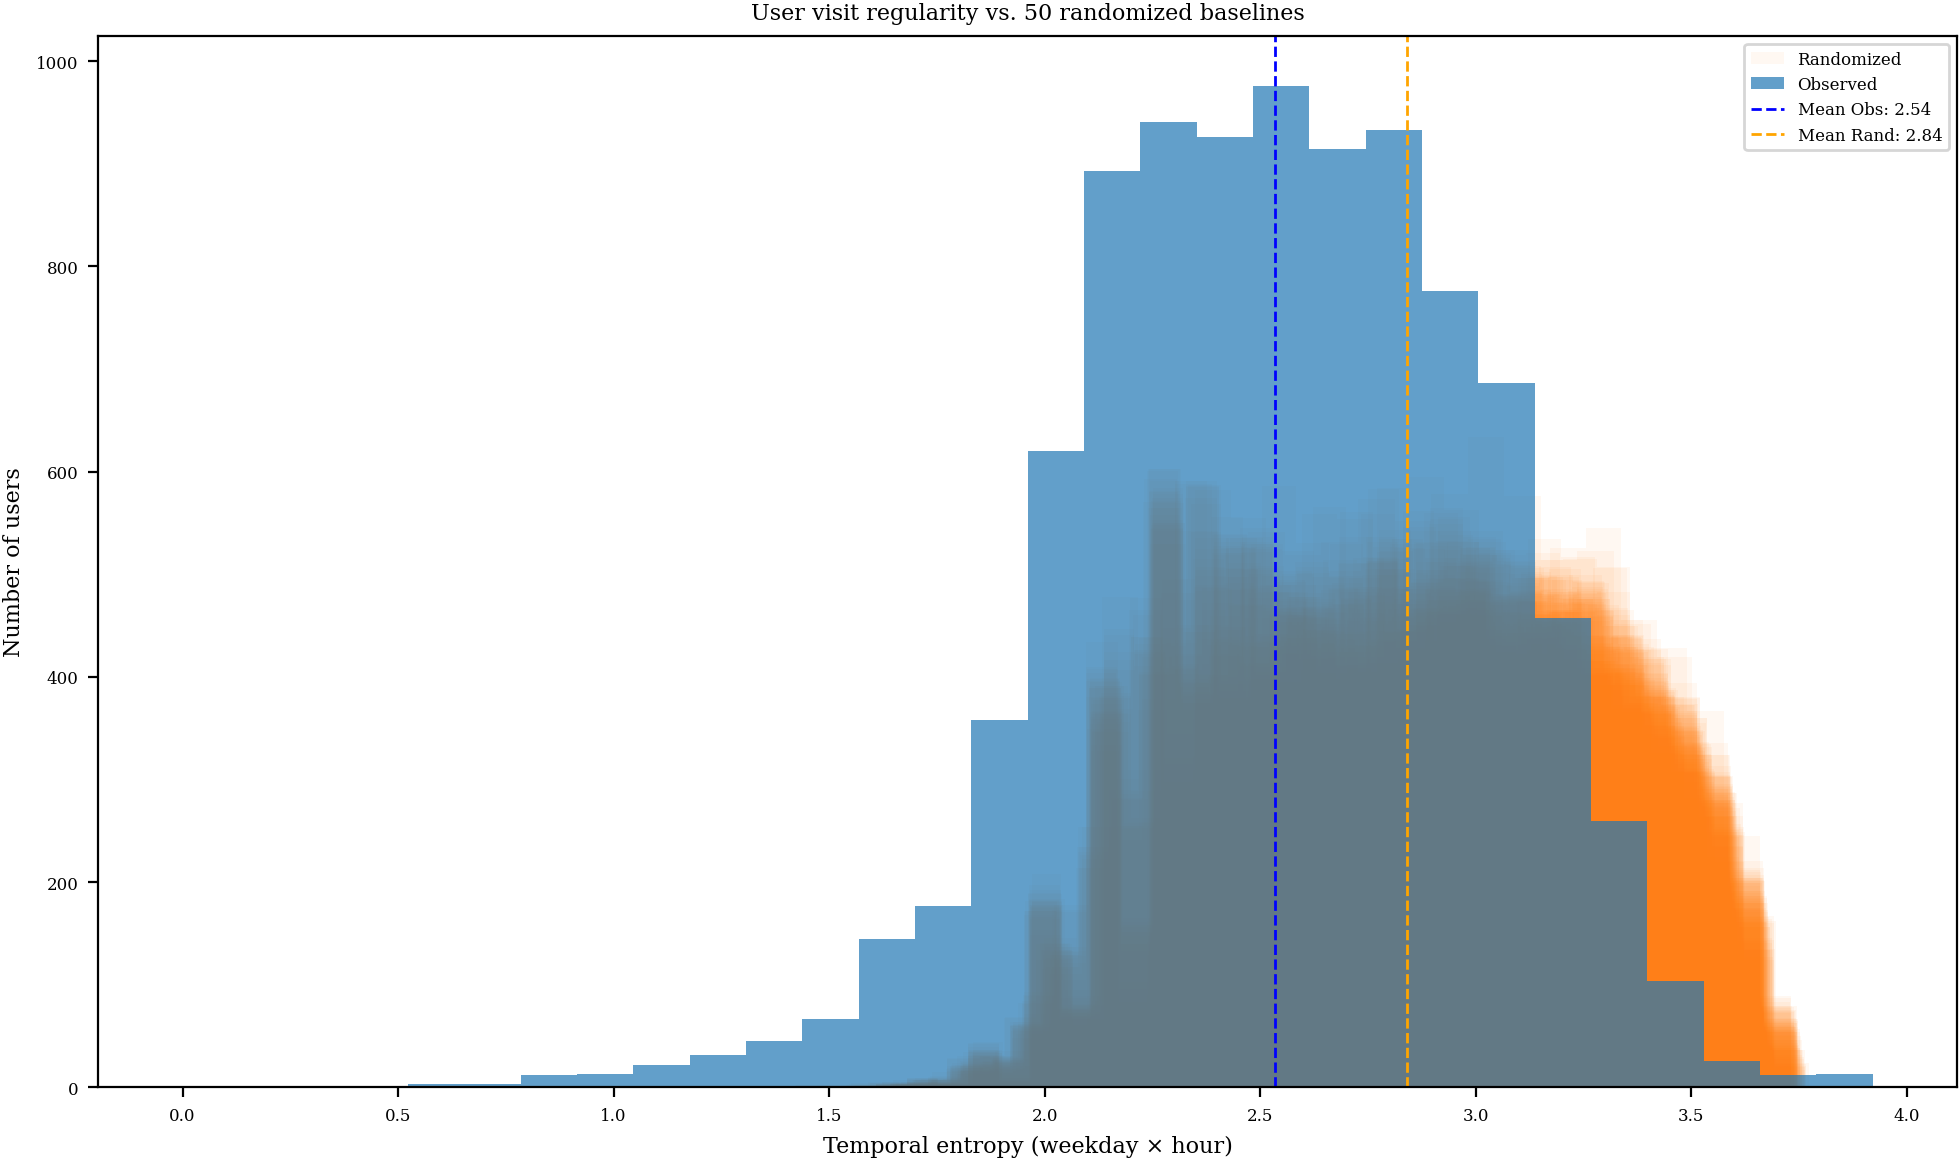

In [15]:
df_plot = user_sessions_clean.copy()
df_plot = df_plot.dropna(subset=[USER_ID_COL, 'weekday', 'hour'])

def get_entropy_series(df_input):
    """Calculates entropy per user using the logic from your source code."""
    counts = df_input.groupby([USER_ID_COL, 'weekday', 'hour']).size().astype(float)
    p = counts / counts.groupby(level=0).transform('sum')
    ent = (-p * np.log(p)).groupby(level=0).sum()
    ent.name = "entropy"
    return ent

entropy_obs = get_entropy_series(df_plot)
obs_mean = entropy_obs.mean()

n_permutations = 50
rng = np.random.default_rng(42)
pairs = df_plot[['weekday', 'hour']].to_numpy()
user_ids_only = df_plot[[USER_ID_COL]].copy()

null_means = []
bins = 30

plt.figure(figsize=(10, 6))

print(f"Calculating {n_permutations} permutations...")
for i in range(n_permutations):
    pairs_shuffled = pairs[rng.permutation(len(pairs))]

    df_rand = user_ids_only.copy()
    df_rand['weekday'] = pairs_shuffled[:, 0]
    df_rand['hour'] = shuffled_pairs[:, 1] if 'shuffled_pairs' in locals() else pairs_shuffled[:, 1]

    ent_rand = get_entropy_series(df_rand)
    null_means.append(ent_rand.mean())

    # Plot orange bars with very low alpha to create the 'cloud'
    plt.hist(ent_rand.values, bins=bins, color='tab:orange', alpha=0.05,
             label="Randomized" if i == 0 else "")

# 5. Observed Data (Blue, like your original plot)
plt.hist(entropy_obs.values, bins=bins, color='tab:blue', alpha=0.7, label="Observed")

# 6. Quantification and P-Value
p_value = (np.array(null_means) <= obs_mean).mean()

# Add mean lines for final quantification
plt.axvline(obs_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Mean Obs: {obs_mean:.2f}')
plt.axvline(np.mean(null_means), color='orange', linestyle='dashed', linewidth=1, label=f'Mean Rand: {np.mean(null_means):.2f}')

plt.title(f"User visit regularity vs. {n_permutations} randomized baselines")
plt.xlabel("Temporal entropy (weekday × hour)")
plt.ylabel("Number of users")
plt.legend()

print("\n--- Quantification of Results ---")
print(f"Mean Entropy (Observed):   {obs_mean:.3f}")
print(f"Mean Entropy (Randomized): {np.mean(null_means):.3f}")
print(f"P-Value:                   {p_value:.4f}")
print("---------------------------------")

plt.tight_layout()
plt.show()

## Plots for the paper

In [16]:
weekday_cutoff = 19.5
saturday_cutoff = 14.5

mask = ~(
    ((user_sessions_clean["weekday"] != "Saturday") &
     (user_sessions_clean["precise_hour"] > weekday_cutoff))
    |
    ((user_sessions_clean["weekday"] == "Saturday") &
     (user_sessions_clean["precise_hour"] > saturday_cutoff))
)

user_sessions_filtered = user_sessions_clean[mask].copy()

removed = len(user_sessions_clean) - len(user_sessions_filtered)
print(f"Removed {removed} sessions as implausible late-day outliers.")


Removed 252 sessions as implausible late-day outliers.


weekday
Tuesday      93638
Wednesday    80615
Friday       79660
Thursday     73766
Saturday     67671
Name: count, dtype: int64


/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_2113/3227169006.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)


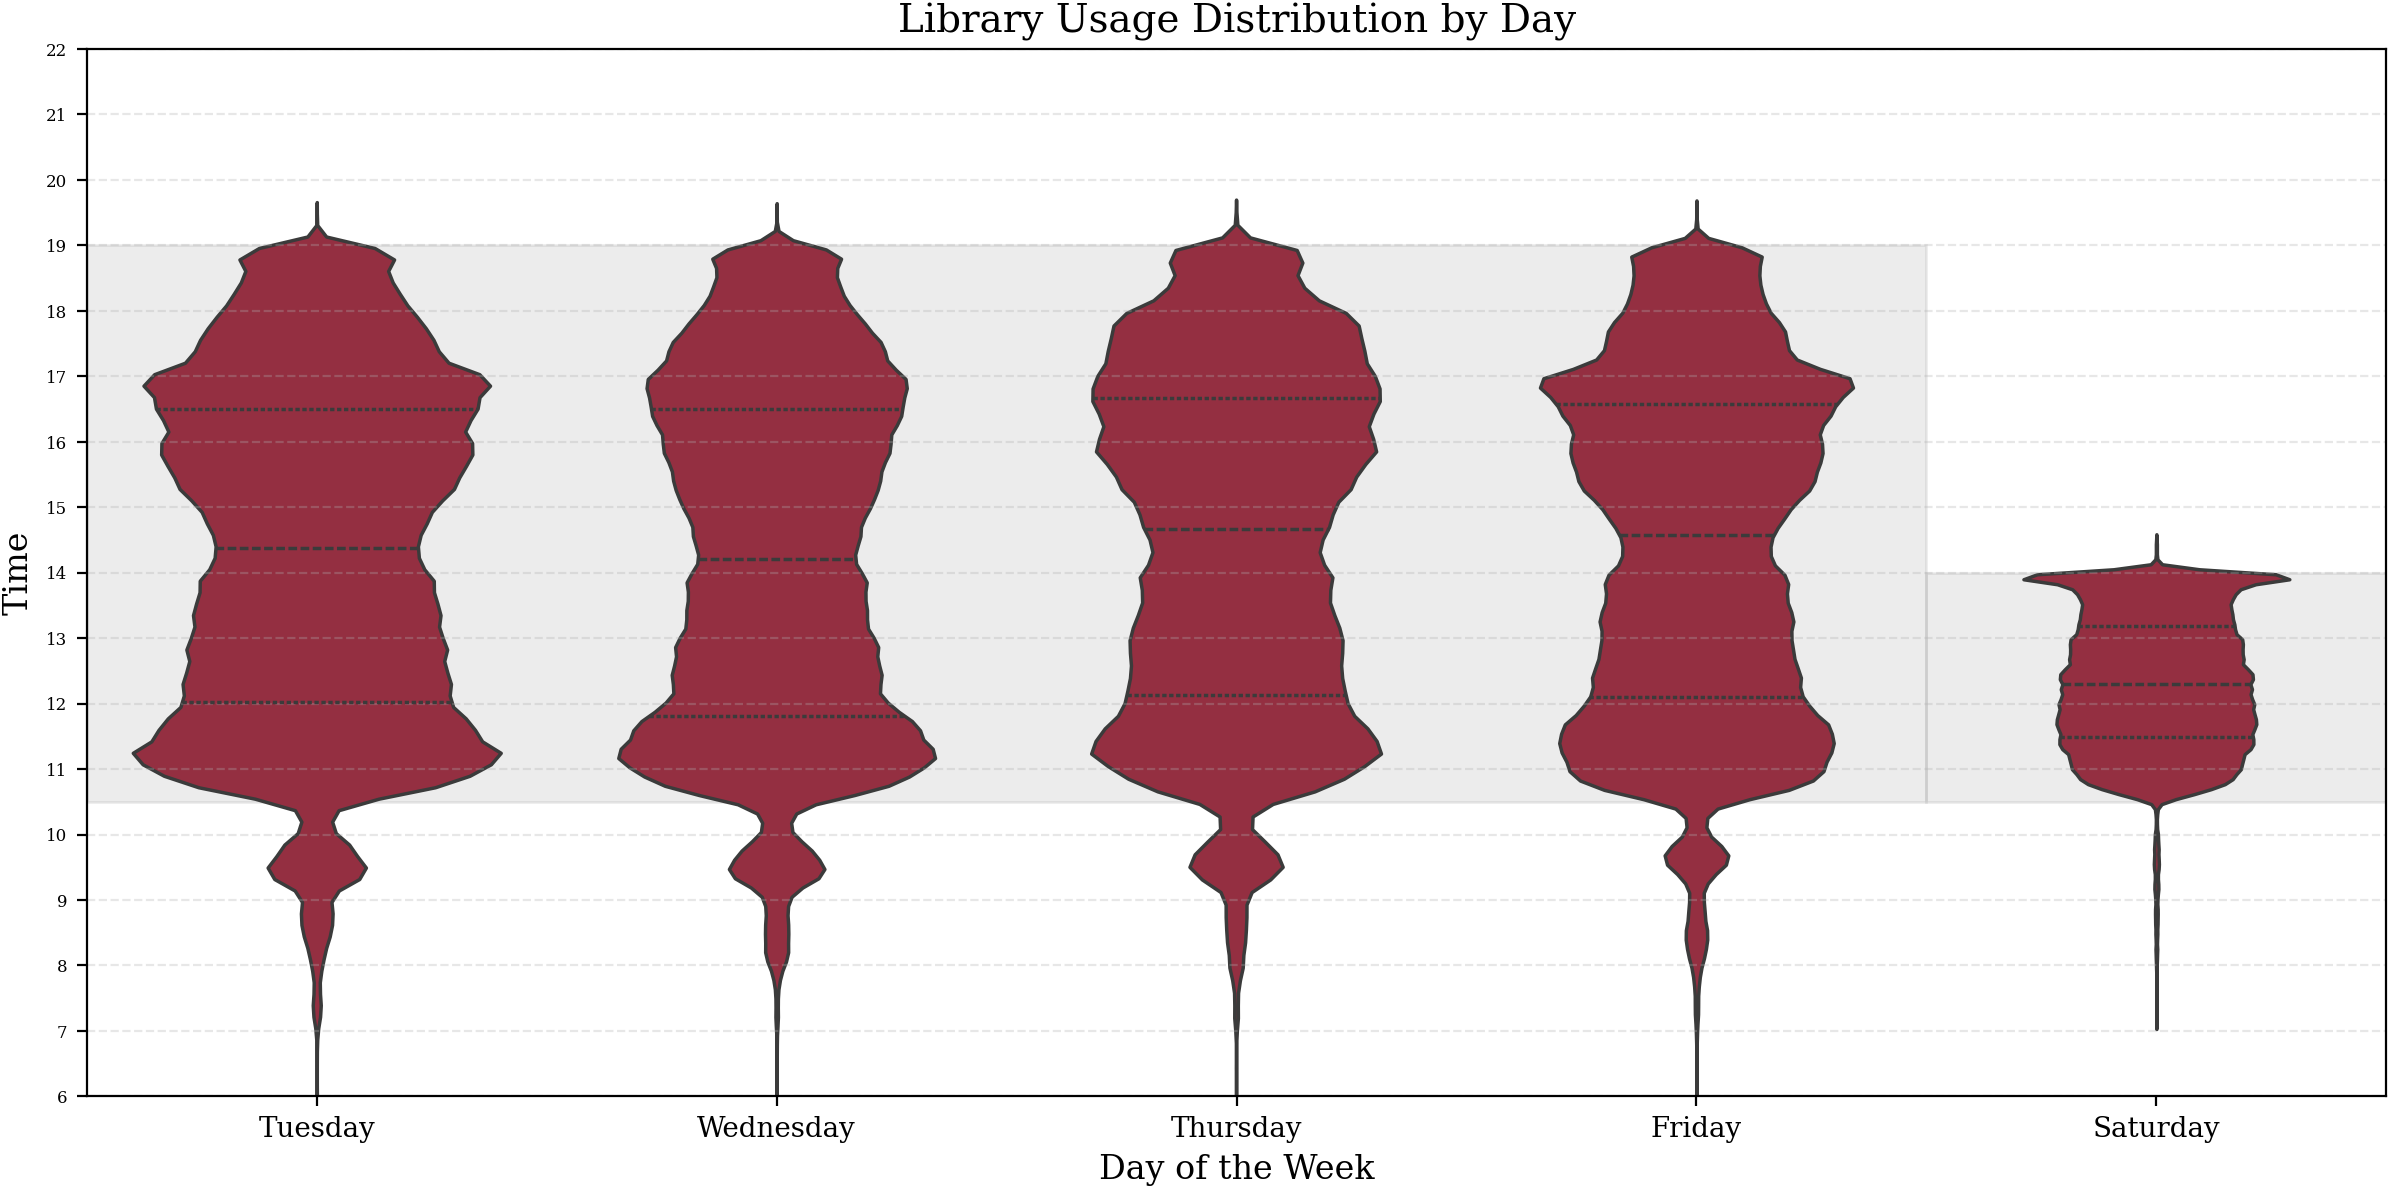

In [17]:
order = [ "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

plt.figure(figsize=(12, 6))


ax =sns.violinplot(
    data=user_sessions_filtered,
    x="weekday",
    y="precise_hour",
    order=order,
    inner="quartile",
    bw_adjust=0.4,
    density_norm='count'
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.add_patch(
    Rectangle(
        (-0.5, 10.5),
        4.0,
        8.5,
        color='gray',
        alpha=0.15,
        zorder=0
    )
)

ax.add_patch(
    Rectangle(
        (3.5, 10.5),
        1.0,
        3.5,
        color='gray',
        alpha=0.15,
        zorder=0
    )
)
counts = user_sessions_filtered['weekday'].value_counts()
print(counts)
plt.ylim(6, 22)
plt.yticks(range(6, 23))
plt.ylabel("Time", fontsize=12)
plt.xlabel("Day of the Week", fontsize=12)
plt.title("Library Usage Distribution by Day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [18]:
count_sat_after_14 = user_sessions_clean[
    (user_sessions_clean['weekday'] == 'Saturday') &
    (user_sessions_clean['precise_hour'] > 15)
].shape[0]

print(f"Number of sessions on Saturday after 14:00: {count_sat_after_14}")


Number of sessions on Saturday after 14:00: 133


/Users/adrianopolzer/Uni/Data_Literacy/Project/Data_Literacy/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


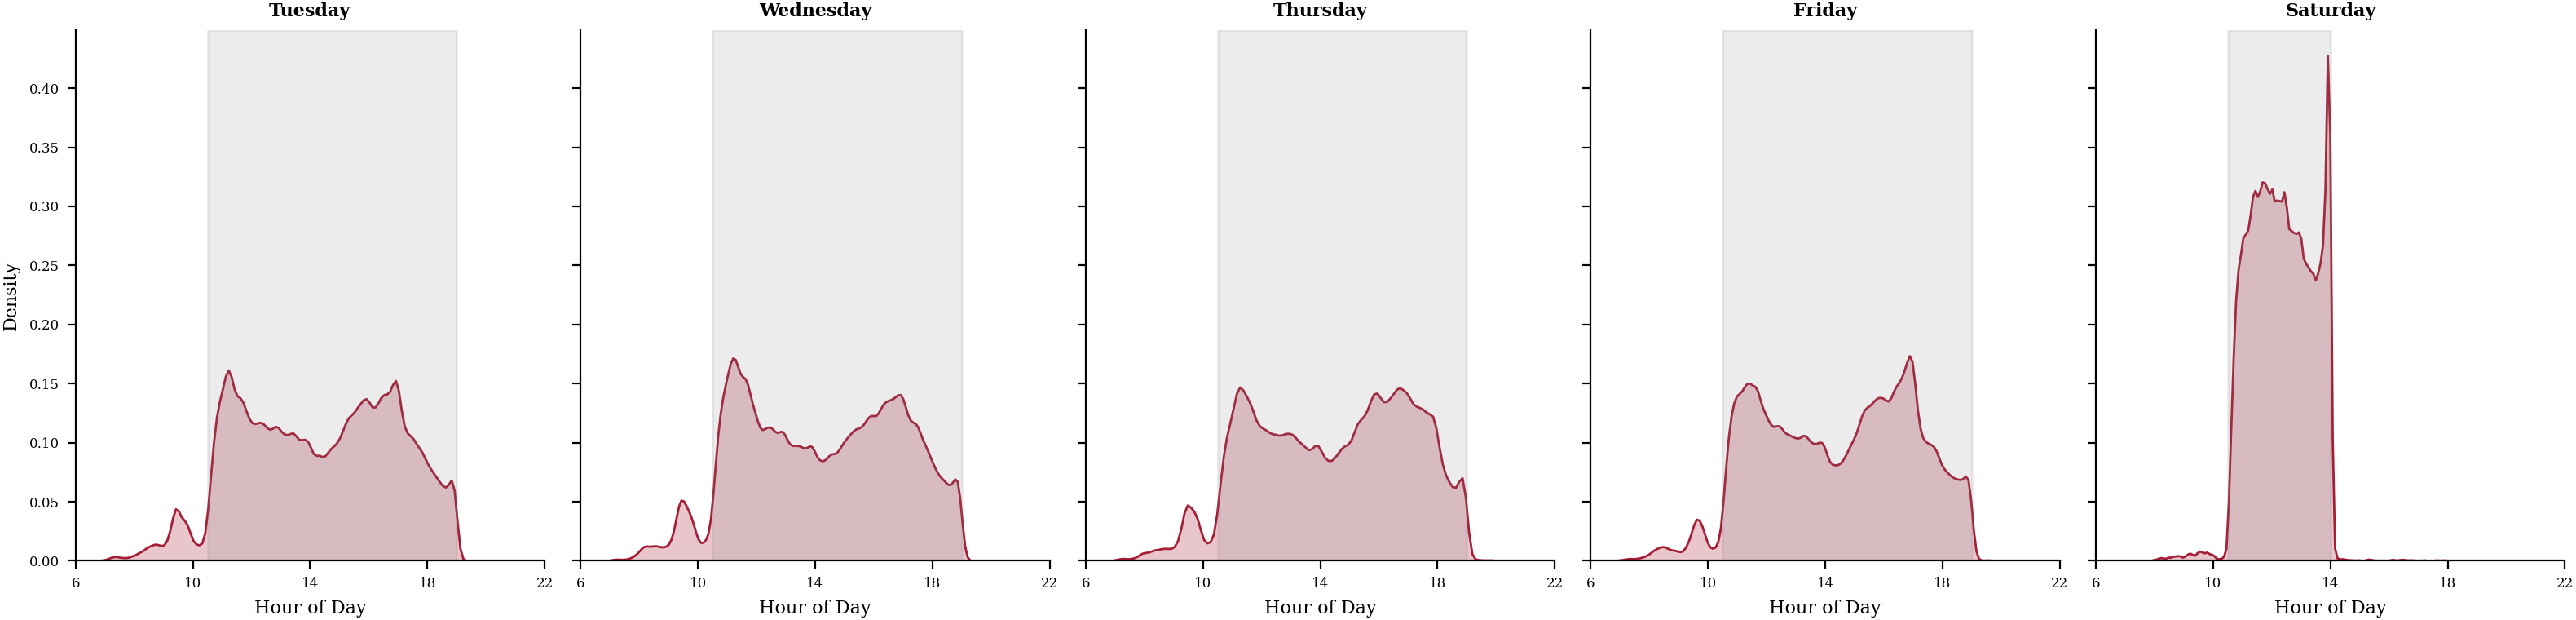

In [19]:
g = sns.FacetGrid(
    user_sessions_clean,
    col="weekday",
    col_order=order,
    height=4,
    aspect=0.8,
    sharey=True
)

g.map_dataframe(
    sns.kdeplot,
    x="precise_hour",
    fill=True,
    bw_adjust=0.4,
)

for ax in g.axes.flat:
    day_name = ax.get_title().split('= ')[-1]

    end_hour = 14.0 if day_name == "Saturday" else 19.0
    ax.axvspan(10.5, end_hour, color='gray', alpha=0.15, label='Opening Hours')
    ax.set_xlim(6, 22)
    ax.set_xticks([6, 10, 14, 18, 22])
    ax.set_title(day_name, fontweight='bold')

g.set_axis_labels("Hour of Day", "Density")
plt.tight_layout()
plt.show()

/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_2113/4153045568.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


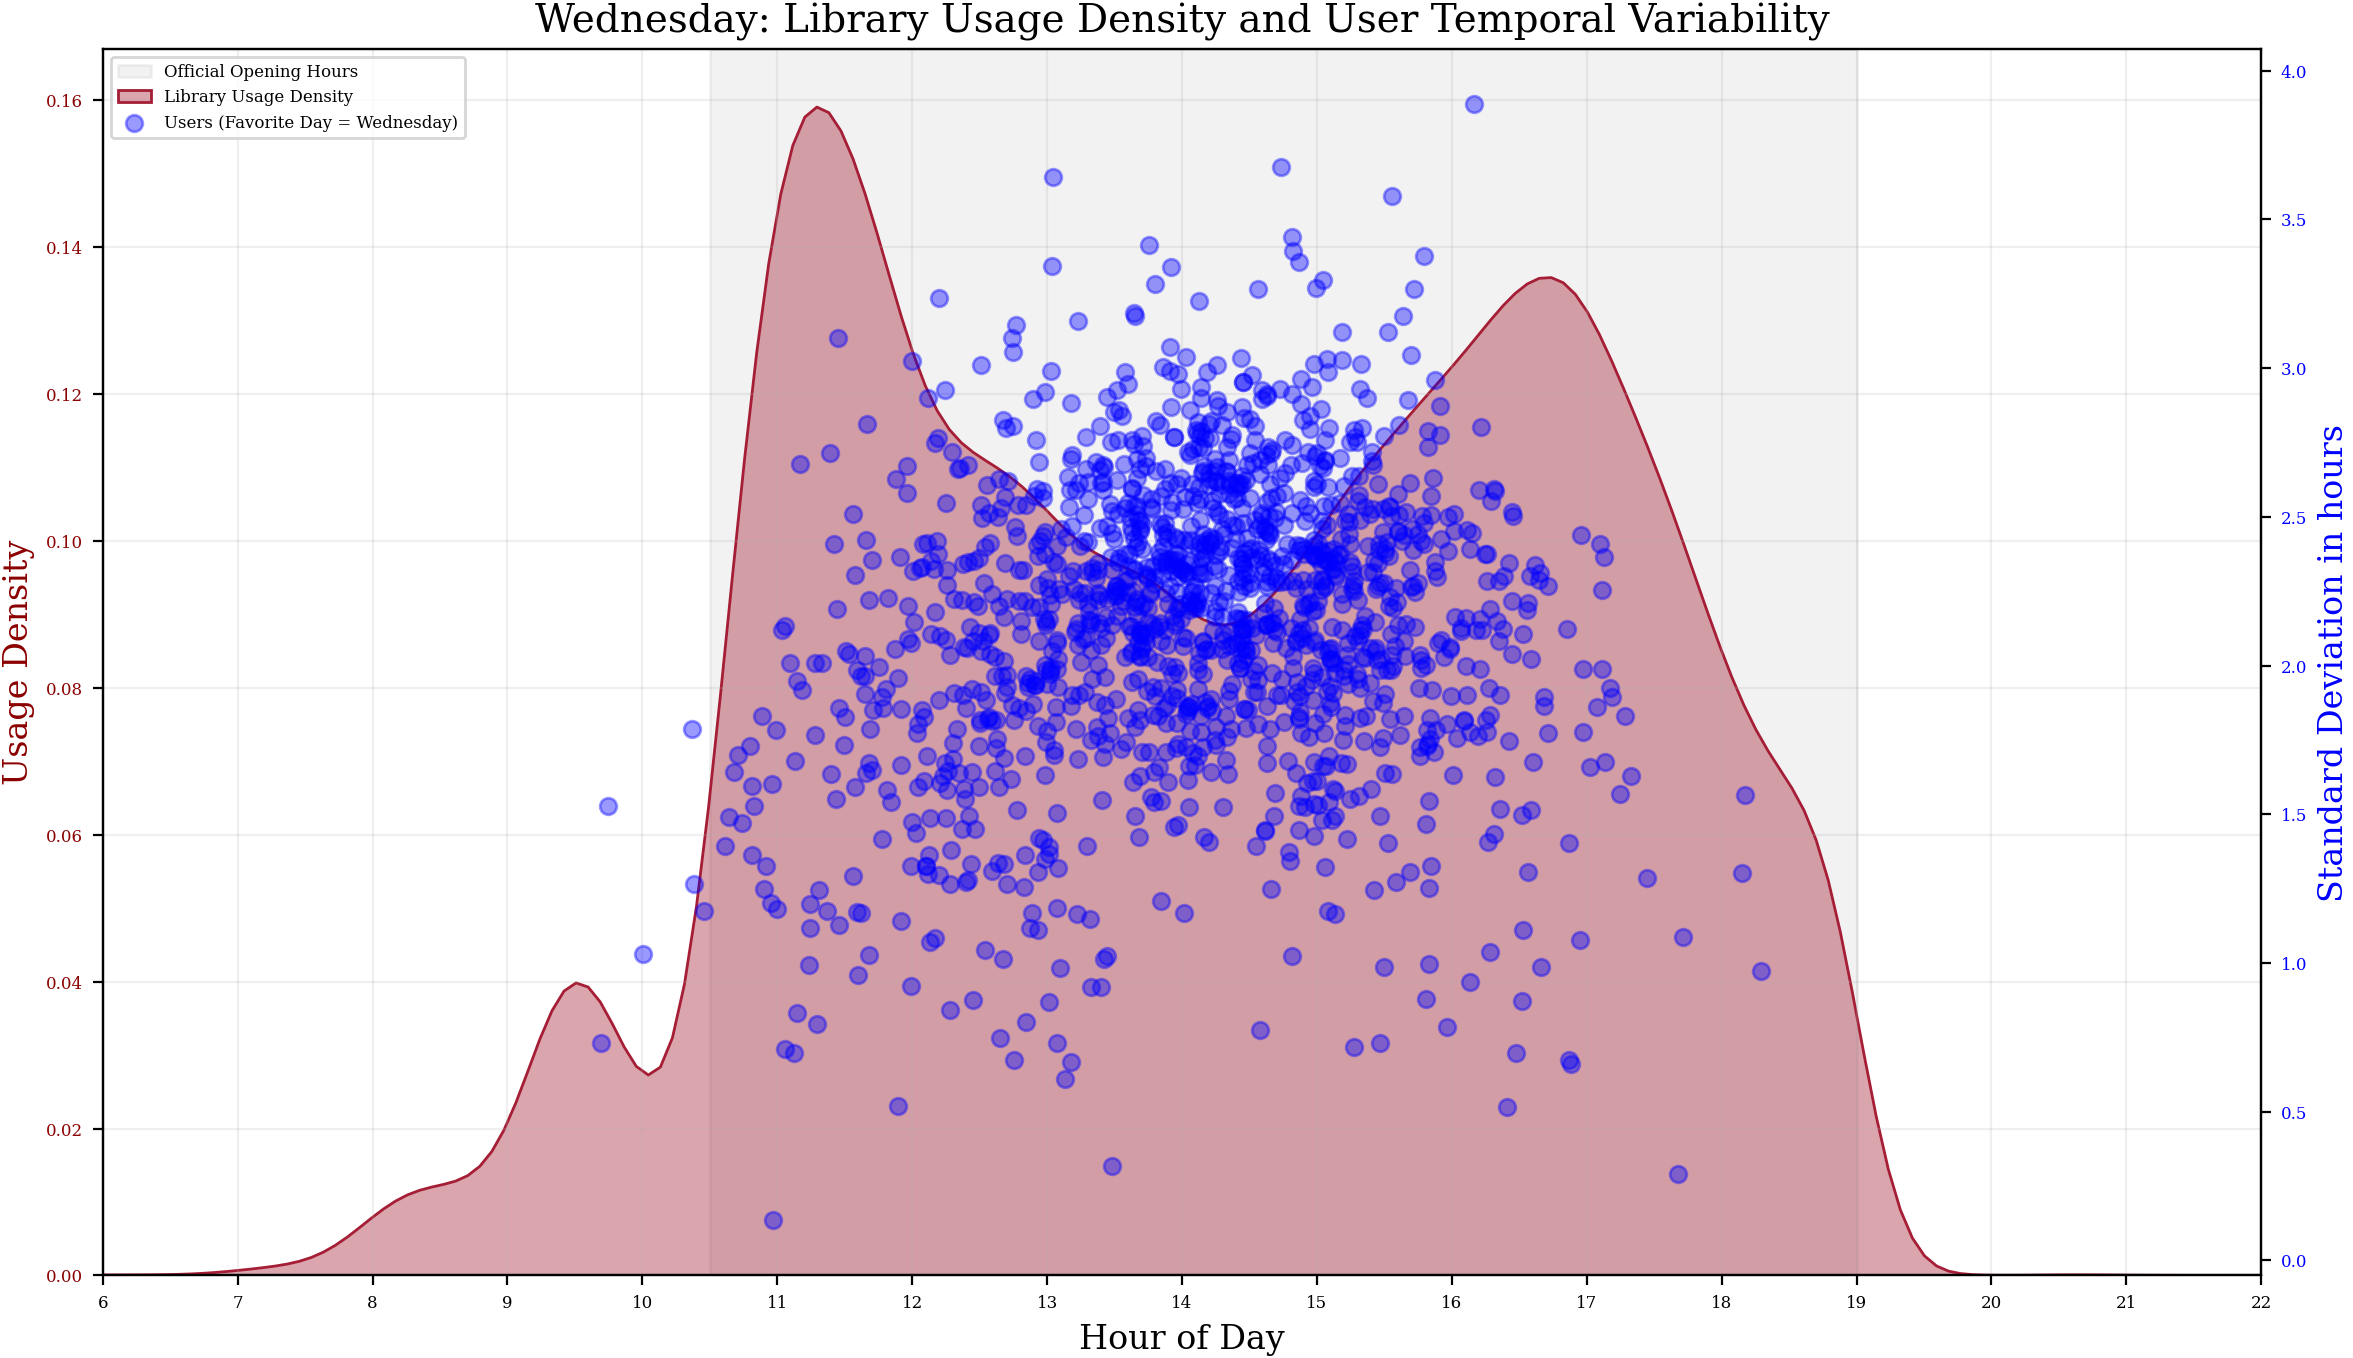

In [20]:
DAY = "Wednesday"


day_data = user_sessions_clean[user_sessions_clean["weekday"] == DAY]
day_behavior = user_time_behavior[user_time_behavior['fav_day'] == DAY].copy()

day_behavior['hour_bin'] = (day_behavior['avg_hour'] * 4).round() / 4
stability_map = day_behavior.groupby('hour_bin').agg({
    'hour_spread': 'mean',
    'visit_count': 'count'
}).reset_index()
stability_map = stability_map[(stability_map['hour_bin'] >= 6) & (stability_map['hour_bin'] <= 22)]

fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.axvspan(10.5, 19.0, color='gray', alpha=0.1, label='Official Opening Hours')
sns.kdeplot(
    data=day_data,
    x="precise_hour",
    fill=True,
    ax=ax1,
    alpha=0.4,
    label='Library Usage Density'
)
ax1.set_ylabel("Usage Density", fontsize=12, color='darkred')
ax1.tick_params(axis='y', labelcolor='darkred')
ax1.set_xlabel("Hour of Day", fontsize=12)

ax2 = ax1.twinx()
ax2.scatter(
    x=day_behavior['avg_hour'],
    y=day_behavior['hour_spread'],
    color='blue',
    alpha=0.4,
    label=f'Users (Favorite Day = {DAY})'
)

ax2.set_ylabel("Standard Deviation in hours", color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f"{DAY}: Library Usage Density and User Temporal Variability", fontsize=14)
plt.xlim(6, 22)
plt.xticks(range(6, 23))
ax1.grid(axis='both', alpha=0.2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

395602
9417
Calculating 100 permutations...
1.0% null-quantile: 1.9730014063936128

--- Quantification of Results ---
Mean Entropy (Observed):   2.535
Mean Entropy (Randomized): 2.841
P-Value:                   0.0000
---------------------------------


/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_2113/1284560835.py:85: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


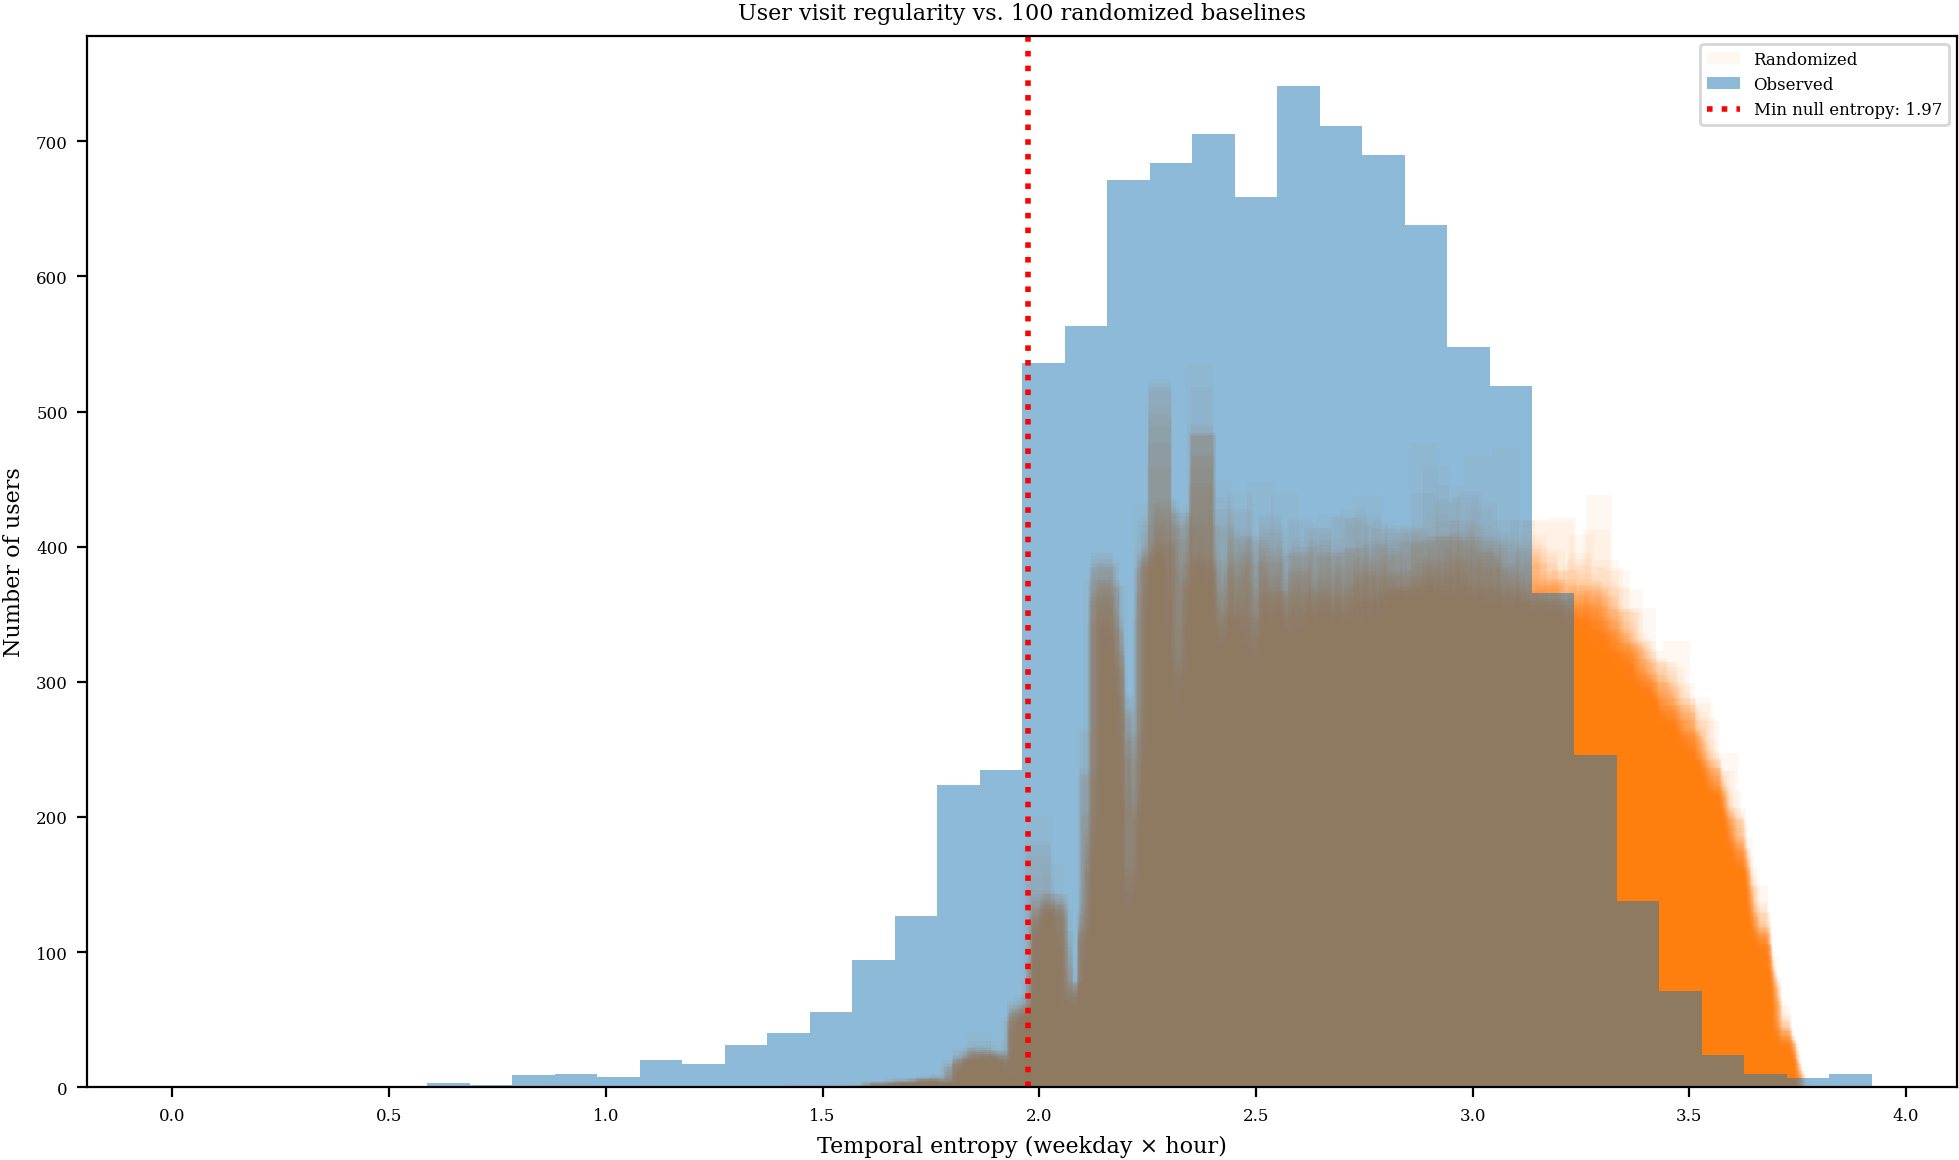

In [21]:
N_PERMUTATIONS = 100

df_plot = user_sessions_clean.copy()
df_plot = df_plot.dropna(subset=[USER_ID_COL, 'weekday', 'hour'])

def get_entropy_series(df_input):
    counts = df_input.groupby([USER_ID_COL, 'weekday', 'hour']).size().astype(float)
    p = counts / counts.groupby(level=0).transform('sum')
    ent = (-p * np.log(p)).groupby(level=0).sum()
    ent.name = "entropy"
    return ent

entropy_obs = get_entropy_series(df_plot)
obs_mean = entropy_obs.mean()

user_ids = entropy_obs.index
n_users = len(user_ids)
null_distributions = np.zeros((n_users, N_PERMUTATIONS))

rng = np.random.default_rng(42)
pairs = df_plot[['weekday', 'hour']].to_numpy()
user_ids_only = df_plot[[USER_ID_COL]].copy()
print(len(df_plot))
print(n_users)
null_means = []
bins = 40

plt.figure(figsize=(10, 6))

print(f"Calculating {N_PERMUTATIONS} permutations...")
for i in range(N_PERMUTATIONS):
    pairs_shuffled = pairs[rng.permutation(len(pairs))]

    df_rand = user_ids_only.copy()
    df_rand['weekday'] = pairs_shuffled[:, 0]
    df_rand['hour'] = pairs_shuffled[:, 1]

    ent_rand = get_entropy_series(df_rand)
    null_means.append(ent_rand.mean())
    null_distributions[:, i] = ent_rand.reindex(user_ids).values

    plt.hist(ent_rand.values, bins=bins, color='tab:orange', alpha=0.05,
             label="Randomized" if i == 0 else "")

plt.hist(entropy_obs.values, bins=bins, color='tab:blue', alpha=0.5, label="Observed")

q = 0.01
null_threshold = np.nanquantile(null_distributions, q)
print(f"{q*100:.1f}% null-quantile:", null_threshold)

p_value = (np.array(null_means) <= obs_mean).mean()
plt.axvline(
    null_threshold,
    color='red',
    linestyle=':',
    linewidth=2,
    label=f'Min null entropy: {null_threshold:.2f}'
)

plt.title(f"User visit regularity vs. {N_PERMUTATIONS} randomized baselines")
plt.xlabel("Temporal entropy (weekday × hour)")
plt.ylabel("Number of users")
plt.legend()

print("\n--- Quantification of Results ---")
print(f"Mean Entropy (Observed):   {obs_mean:.3f}")
print(f"Mean Entropy (Randomized): {np.mean(null_means):.3f}")
print(f"P-Value:                   {p_value:.4f}")
print("---------------------------------")

plt.tight_layout()
plt.show()